Solving thermal conductivity (poisson) on a $2D$ mesh. Discrete Galerkin form:


Find $u_h\in\mathcal{U}_h \subset \mathcal{U}$,
$$\ni \int_{\Omega_h} \nabla (\delta u)\ \kappa \nabla (u_h)\ dx = \int_{\partial\Omega_h}\bar{\bf q}\cdot \delta u dx\quad  \forall \delta u \in \mathcal{U}^0_h$$

In this case $\mathcal{U}_h$ is nothing but the space of quadratic polynomials over each triangle $\mathcal{T}_h\in\Omega_h$, i.e. $\mathcal{U}_h = \bigcup\limits_{\mathcal{T}_h\in\Omega_h}\mathcal{P}^2\left(\mathcal{T}_h\right)$

In [1]:
from dolfin import *
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import cm
from jupyterthemes import jtplot
jtplot.style()
plt.rc("text", usetex=True)
plt.rcParams['font.weight'] = 700
plt.rcParams['xtick.top']='True'
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.right']='True'
plt.rcParams['ytick.direction']='in'
plt.rcParams['ytick.labelsize']=22
plt.rcParams['xtick.labelsize']=22
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.major.size']=6
plt.rcParams['xtick.minor.size']=3
plt.rcParams['ytick.major.size']=6
plt.rcParams['ytick.minor.size']=3
plt.rcParams['lines.markersize']=np.sqrt(36)

In [2]:
leftpt = CompiledSubDomain("near(x[0], -0.1, 1.e-8) && near(x[1], 0, 1.e-8)")
right = CompiledSubDomain("near(x[0], 0.1) && on_boundary")
left = CompiledSubDomain("near(x[0], -0.1) && on_boundary")
top = CompiledSubDomain("near(x[1], 0.1) && on_boundary")
bottom = CompiledSubDomain("near(x[1], -0.1) && on_boundary")
circ = CompiledSubDomain("near((pow(x[0],2) + pow(x[1],2))/pow(0.025, 2), 1, 0.1 ) && on_boundary")

In [3]:
def solveThermalConductivity(msh, calculate_error=False):
    """ solve a simple thermal conductivity problem"""
    bdryMark = MeshFunction("size_t", msh, msh.geometry().dim() - 1)
    bdryMark.set_all(0)

    right.mark(bdryMark, 1)
    top.mark(bdryMark, 2)
    left.mark(bdryMark, 3)
    bottom.mark(bdryMark, 4)
    
    V = FunctionSpace(msh, "CG", 2)
    Vq = VectorFunctionSpace(msh, "DG", 1)
    u_ = TrialFunction(V)
    du = TestFunction(V)
    u = Function(V)
    ds = Measure("ds", subdomain_data = bdryMark)


    alph1 = Constant(10.)
    alph2 = Constant(-10.)
    ue_exp = Expression(("a1/2*pow(x[1],2)"),a1=float(alph1),degree=2)
    
    a = 1*inner(grad(u_), grad(du))*dx
    L =  inner(alph2, du)*ds(4) + inner(alph1, du)*ds(2) #+ inner(sbar, du)*dx 
    A = assemble(a)
    b = assemble(L)
    
    solver = PETScKrylovSolver("cg")
    solver.set_operator(A)
    
    null_vec = Vector(u.vector())
    V.dofmap().set(null_vec, 1.0)
    null_vec *= 1.0/null_vec.norm("l2")

    # Create null space basis object and attach to PETSc matrix
    null_space = VectorSpaceBasis([null_vec])
    as_backend_type(A).set_nullspace(null_space)
    
    null_space.orthogonalize(b)
    
    solver.solve(u.vector(), b)

    return u, msh.hmax()

In [4]:
msh = Mesh()
errs = []
meshSize = []
XDMFFile(os.path.join(os.getcwd(), "meshes2D","mesh_{}.xdmf".format(3))).read(msh)
for i in range(2):
    msh = refine(msh)
uexact, _ = solveThermalConductivity(msh) 
for i in range(2):
    XDMFFile(os.path.join(os.getcwd(), "meshes2D","mesh_{}.xdmf".format(i+1))).read(msh)
    u, h = solveThermalConductivity(msh)
    err = errornorm(u, uexact, "l2", mesh=msh)/norm(uexact, "l2", mesh=msh)
    errs.append(err)
    meshSize.append(h)
errs
# plt.figure(figsize=(8,8))
# plt.loglog(meshSize, errs)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


[1.1794966575716561, 1.260713967389419]

In [ ]:
print((np.log(errs[1:])-np.log(errs[:-1]))/(np.log(meshSize[1:])-np.log(meshSize[:-1])))

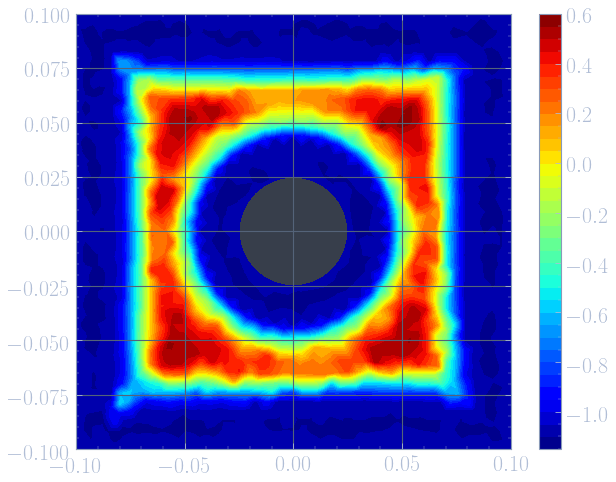

In [5]:
plt.figure(figsize=(10,8))
p1 = plot(uexact, cmap=cm.jet)
plt.colorbar(p1)

Text(0.5, 1.0, 'Temperature: $T(x,y)$')

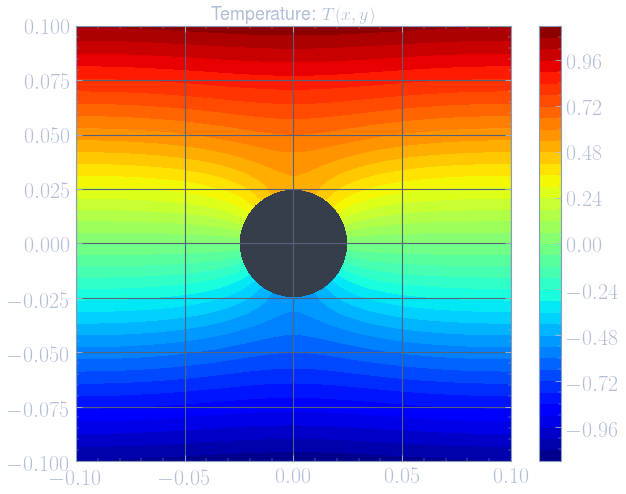

In [6]:
plt.figure(figsize=(10,8))
p1 = plot(u, cmap=cm.jet)
plt.colorbar(p1)
plt.title("Temperature: $T(x,y)$", fontsize=18)

In [8]:
q = project(grad(u), VectorFunctionSpace(msh, "DG", 1))

Text(0.5, 1.0, 'Flux: $q_1 = -\\frac{\\partial T}{\\partial {x}}$')

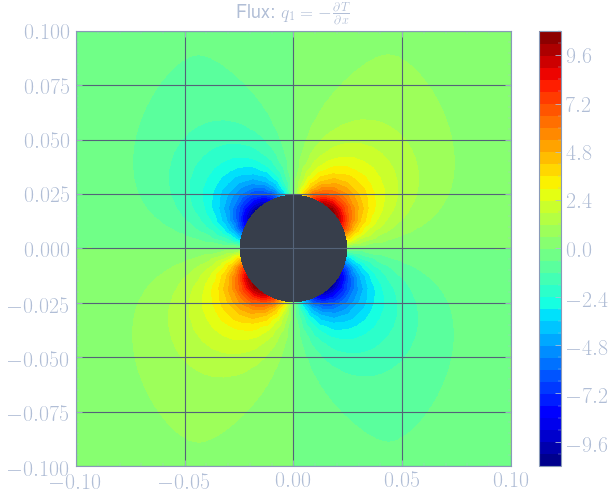

In [9]:
plt.figure(figsize=(10,8))
q1 = plot(-q[0], cmap=cm.jet)
plt.colorbar(q1)
plt.title(r"Flux: $q_1 = -\frac{\partial T}{\partial {x}}$", fontsize=18)

Text(0.5, 1.0, 'Flux: $q_2 = -\\frac{\\partial T}{\\partial {y}}$')

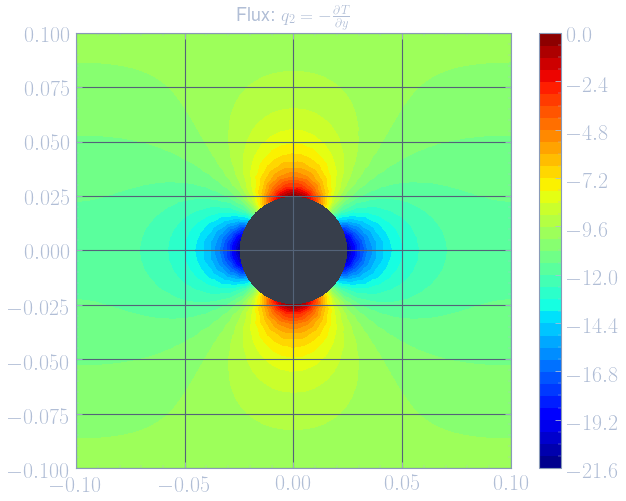

In [10]:
plt.figure(figsize=(10,8))
q2 = plot(-q[1], cmap=cm.jet)
plt.colorbar(q2)
plt.title(r"Flux: $q_2 = -\frac{\partial T}{\partial {y}}$", fontsize=18)